## Introdução à Aprendizagem Profunda
**LISTA PRÁTICA DAS UNIDADES 1 E 2**
- Discente: Vitor Negromonte (vnco)
- Período: 2023.2

## Instruções e requisitos

- Pode ser feita com o grupo do projeto. Recomendo pair/group programming para que todos vejam um pouco de todas as partes.

- Treine e avalie 4 modelos de classificação para a base de dados do FashionMNIST (https://www.kaggle.com/datasets/zalando-research/fashionmnist,
https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).


1.   Um modelo base que não seja uma rede neural, como _decision tree, xgboost, random forest_, etc. Recomendação: use o sklearn (https://scikit-learn.org/).

2.   Uma MLP

3. Uma rede convolucional criada por ti. Recomendação: https://pytorch.org/

4. Use um modelo pré treinado já consolidado na literatura para fazer _transfer learning_. Recomendações: https://pytorch.org/hub/pytorch_vision_vgg/


Compare os resultados dos modelos:
* plote gráficos que mostrem as acurácias de cada modelo
* Indique qual foi a classe na qual o modelo teve pior performance (indique qual métrica usou para concluir isso e faça para cada modelo)
* argumente qual o melhor modelo levando em consideração o tempo de execução e acurácia.

Recomendação use:
https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html .

Recomendação:

Faça um template de treino, validação e teste que funcione para uma API de modelo.

Crie a API para cada modelo que será usado e use o template

## Imports e Downloads

### Imports

In [1]:
import random
import time
import os

import pandas as pd
import numpy as np
import torch, torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from torch.utils.data import DataLoader, TensorDataset

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


### Downloading the dataset

In [2]:
# Load the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

viz_train_x = train_dataset.data
viz_train_y = train_dataset.targets

100%|██████████| 26421880/26421880 [00:01<00:00, 15363898.40it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 280901.29it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4902631.42it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19159074.53it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Data preparation

In [3]:
# Reshape and normalizing the dataset
train_x = train_dataset.data.view(train_dataset.data.shape[0], -1).float() / 255.0
test_x = test_dataset.data.view(test_dataset.data.shape[0], -1).float() / 255.0

train_y = train_dataset.targets
test_y = test_dataset.targets

### Functions and constants

In [4]:
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
MODELS_LISTS = []
ACCURACIES = []
EXECUTION_TIMES = []
MOST_DIFFICULT_CLASS = []
TPR_MIN = []

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to return the execution time of a model
def get_execution_time(model):
    start_time = time.time()
    model.fit(train_x, train_y)
    end_time = time.time()
    return end_time - start_time

# Function to evaluate a base model and return the accuracy, confusion matrix, classification report and execution time
def evaluate_base_model(name, model, exec_time):
    y_pred = model.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print(f"Accuracy of {name}: {accuracy:.4f}\n")

    print(f'Execution time: {exec_time} \n')

    conf_matrix_result = confusion_matrix(test_y, y_pred)
    print('Classification Report')
    print(classification_report(test_y, y_pred))

    print('\nConfusion Matrix')
    print(conf_matrix_result)
    print(f'Execution time {exec_time} seconds\n')

    TPR = conf_matrix_result.diagonal() / conf_matrix_result.sum(axis=1)
    print('True Positive Rate:')
    print(f'TPR: {TPR} \n')

    print(f'Most dificult class {TPR.argmin()}')
    MODELS_LISTS.append(name)
    ACCURACIES.append(accuracy)
    EXECUTION_TIMES.append(exec_time)
    MOST_DIFFICULT_CLASS.append(TPR.argmin())
    TPR_MIN.append(TPR.min())

    return accuracy, conf_matrix_result, classification_report, exec_time, TPR_MIN

def train_neural_network(model_name, model, train_loader, epochs, DEVICE='cuda'):
    # Define the loss function and optimizer and metrics
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    metrics = ['accuracy']
    num_epochs = epochs

    start_time = time.time()

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)  # Move data to GPU
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    end_time = time.time()
    exec_time = end_time - start_time

    return exec_time

def evaluate_model(model_name, model, test_data_tensor, test_labels_tensor, exec_time):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(test_data_tensor)
        _, predicted = torch.max(outputs.data, 1)
        total = test_labels_tensor.size(0)
        correct = (predicted == test_labels_tensor).sum().item()
        accuracy = correct / total

       # Print the classification report and confusion matrix
        print('Classification Report')
        class_report = classification_report(test_labels_tensor.cpu(), predicted.cpu())
        print(class_report)

        print('\nConfusion Matrix')
        conf_matrix = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        print(conf_matrix)

        # Print true positive rate for each class
        TPR = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        print('\nTrue Positive Rate')
        print(f'TPR: {TPR}')

        # Print the most difficult class with the class number and name
        most_difficult_class = TPR.argmin()
        print(f'\nThe most difficult class is {most_difficult_class} - {CLASS_NAMES[most_difficult_class]}')

        print(f'\nExecution time: {exec_time} seconds')

        # Append results to lists
        MODELS_LISTS.append(model_name)
        ACCURACIES.append(accuracy)
        EXECUTION_TIMES.append(exec_time)
        MOST_DIFFICULT_CLASS.append(most_difficult_class)
        TPR_MIN.append(TPR.min())

    return accuracy, conf_matrix, class_report, exec_time, TPR_MIN

## Exploratory Data Analysis (EDA)



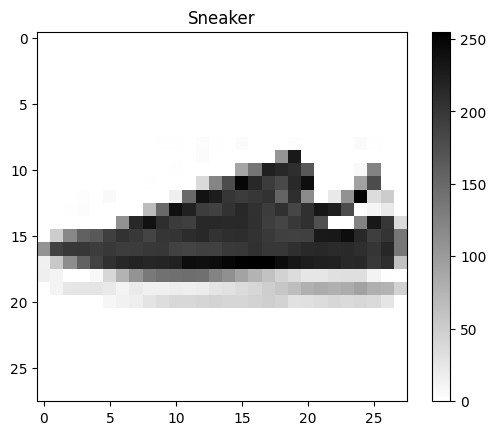

In [5]:
plt.figure()
plt.imshow(viz_train_x[6], cmap=plt.cm.binary)
plt.title(CLASS_NAMES[viz_train_y[6]])
plt.colorbar()
plt.grid(False)
plt.show()

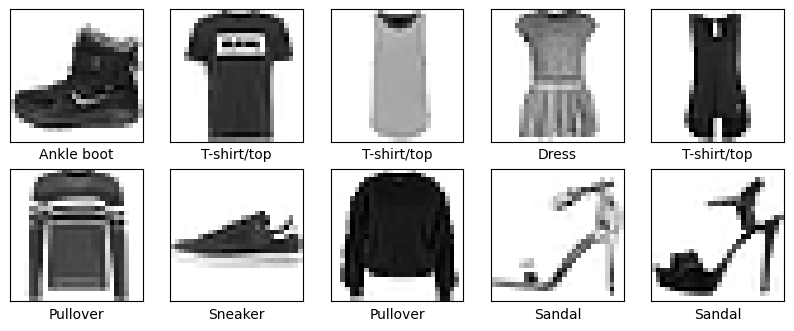

In [6]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(viz_train_x[i], cmap=plt.cm.binary)
    plt.xlabel(CLASS_NAMES[viz_train_y[i]])
plt.show()

In [7]:
# Distribution of the labels in the traing dataset with numbers in each class
unique, counts = np.unique(train_y, return_counts=True)
print("Distribuição de frequência das classes do conjunto de treinamento: \n", dict(zip(unique, counts)), "\n")

# Create a DataFrame for plotting
data = {'Class': unique, 'Count': counts}
df = pd.DataFrame(data)

fig = px.bar(df, x='Class', y='Count', text='Count',
             labels={'Count': 'Frequency', 'Class': 'Class'},
             title='Distribution of Labels in Training Dataset',
             width=1000, height=600)

fig.show()

Distribuição de frequência das classes do conjunto de treinamento: 
 {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000} 



In [8]:
# Distribution of the labels in the test dataset with numbers in each class
unique, counts = np.unique(test_y, return_counts=True)
print("Distribuição de frequência das classes do conjunto de teste: \n", dict(zip(unique, counts)), '\n')

# Create a DataFrame for plotting
data = {'Class': unique, 'Count': counts}
df = pd.DataFrame(data)

fig = px.bar(df, x='Class', y='Count', text='Count',
             labels={'Count': 'Frequency', 'Class': 'Class'},
             title='Distribution of Labels in Training Dataset',
             width=1000, height=600)

fig.show()

Distribuição de frequência das classes do conjunto de teste: 
 {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000} 



# Base Models

## Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    criterion = 'entropy',
    max_depth=100,
    random_state=42)

rf_exec_time = get_execution_time(rf_classifier)

evaluate_base_model(
    'Random Forest',
    rf_classifier,
    rf_exec_time)


Accuracy of Random Forest: 0.8773

Execution time: 98.29899406433105 

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.77      0.80      0.78      1000
           3       0.88      0.91      0.89      1000
           4       0.76      0.81      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.59      0.65      1000
           7       0.93      0.96      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix
[[867   0  13  27   4   1  76   0  12   0]
 [  3 964   3  20   4   0   5   0   1   0]
 [ 13   0 798  10 121   0  53   0   5   0]
 

(0.8773,
 array([[867,   0,  13,  27,   4,   1,  76,   0,  12,   0],
        [  3, 964,   3,  20,   4,   0,   5,   0,   1,   0],
        [ 13,   0, 798,  10, 121,   0,  53,   0,   5,   0],
        [ 18,   2,   9, 908,  28,   0,  33,   0,   2,   0],
        [  0,   0,  94,  38, 811,   0,  53,   0,   4,   0],
        [  0,   0,   0,   1,   0, 957,   0,  29,   1,  12],
        [158,   1, 117,  30,  88,   0, 587,   0,  19,   0],
        [  0,   0,   0,   0,   0,  11,   0, 958,   0,  31],
        [  0,   2,   4,   1,   5,   2,   7,   5, 974,   0],
        [  0,   0,   0,   0,   0,   8,   0,  40,   3, 949]]),
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 98.29899406433105,
 [0.587])

## Suport Vector Machine

### Suport Vector Linear Classifier

In [ ]:
svm_classifier = SVC(
    kernel='linear',
    random_state=42)


svm_exec_time = get_execution_time(svm_classifier)

evaluate_base_model('SVCLinear',
                    svm_classifier,
                    svm_exec_time)

Accuracy of SVCLinear: 0.8463

Execution time: 362.34680938720703 

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1000
           1       0.97      0.96      0.97      1000
           2       0.73      0.77      0.75      1000
           3       0.85      0.84      0.85      1000
           4       0.76      0.77      0.77      1000
           5       0.93      0.94      0.93      1000
           6       0.63      0.56      0.59      1000
           7       0.92      0.93      0.93      1000
           8       0.95      0.93      0.94      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Confusion Matrix
[[815   2  13  45   4   1 108   0  12   0]
 [  6 962   2  22   3   0   4   0   1   0]
 [ 22   6 769   8 109   0  79   0   7   0]
 [ 5

(0.8463,
 array([[815,   2,  13,  45,   4,   1, 108,   0,  12,   0],
        [  6, 962,   2,  22,   3,   0,   4,   0,   1,   0],
        [ 22,   6, 769,   8, 109,   0,  79,   0,   7,   0],
        [ 54,  15,  19, 842,  27,   0,  40,   0,   3,   0],
        [  1,   2, 114,  33, 773,   0,  72,   0,   5,   0],
        [  1,   0,   0,   1,   0, 936,   0,  38,   3,  21],
        [174,   2, 122,  30,  93,   0, 562,   0,  17,   0],
        [  0,   0,   0,   0,   0,  38,   0, 934,   1,  27],
        [ 12,   1,   8,   8,   2,  15,  25,   4, 925,   0],
        [  0,   0,   0,   0,   0,  15,   1,  39,   0, 945]]),
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 362.34680938720703,
 [0.587, 0.562])

### Suport Vector Classifier

In [ ]:
svm_classifier = SVC(
    kernel='rbf',
    C=10,
    random_state=42)

svm_exec_time = get_execution_time(svm_classifier)

evaluate_base_model('SVM',
                    svm_classifier,
                    svm_exec_time)

Accuracy of SVM: 0.9002

Execution time: 258.6090292930603 

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.84      0.82      1000
           3       0.90      0.91      0.91      1000
           4       0.83      0.83      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.75      0.72      0.73      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Confusion Matrix
[[853   0  13  21   6   1 100   0   6   0]
 [  3 973   2  17   3   0   2   0   0   0]
 [ 20   3 836   9  74   0  56   0   2   0]
 [ 24   2  

(0.9002,
 array([[853,   0,  13,  21,   6,   1, 100,   0,   6,   0],
        [  3, 973,   2,  17,   3,   0,   2,   0,   0,   0],
        [ 20,   3, 836,   9,  74,   0,  56,   0,   2,   0],
        [ 24,   2,  13, 910,  27,   0,  19,   0,   5,   0],
        [  0,   1,  82,  21, 835,   0,  60,   0,   1,   0],
        [  0,   0,   0,   1,   0, 974,   0,  17,   1,   7],
        [114,   1,  82,  24,  54,   0, 718,   0,   7,   0],
        [  0,   0,   0,   0,   0,  16,   0, 962,   0,  22],
        [  3,   0,   3,   3,   3,   2,   3,   3, 980,   0],
        [  0,   0,   0,   0,   0,   8,   1,  30,   0, 961]]),
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 258.6090292930603,
 [0.587, 0.562, 0.718])

## Decision Tree

In [ ]:
dt_classifier = DecisionTreeClassifier(
    random_state=42,
     max_depth = 10,
    splitter='best',
    min_samples_split=2)

dt_exec_time = get_execution_time(dt_classifier)

evaluate_base_model(
    'Decision tree',
    dt_classifier,
    dt_exec_time)

Accuracy of Decision tree: 0.8008

Execution time: 21.846704244613647 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1000
           1       0.97      0.92      0.95      1000
           2       0.65      0.67      0.66      1000
           3       0.82      0.81      0.82      1000
           4       0.60      0.73      0.66      1000
           5       0.94      0.86      0.90      1000
           6       0.57      0.50      0.53      1000
           7       0.86      0.93      0.90      1000
           8       0.93      0.90      0.91      1000
           9       0.91      0.91      0.91      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000


Confusion Matrix
[[774   3  25  40  12   0 132   1   9   4]
 [ 13 924   4  40   7   0  10   0   1   1]
 [ 13   1 665   8 242   0  62   0   8   1]


(0.8008,
 array([[774,   3,  25,  40,  12,   0, 132,   1,   9,   4],
        [ 13, 924,   4,  40,   7,   0,  10,   0,   1,   1],
        [ 13,   1, 665,   8, 242,   0,  62,   0,   8,   1],
        [ 32,  10,  26, 811,  62,   2,  50,   0,   6,   1],
        [  4,   0, 124,  39, 734,   0,  96,   0,   3,   0],
        [  2,   4,   0,   1,   1, 864,   0,  70,  21,  37],
        [135,   4, 164,  38, 140,   2, 499,   0,  15,   3],
        [  0,   0,   0,   0,   0,  27,   0, 928,   6,  39],
        [  5,   2,  17,  10,  20,   7,  27,   9, 901,   2],
        [  1,   0,   1,   0,   0,  21,   1,  65,   3, 908]]),
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 21.846704244613647,
 [0.587, 0.562, 0.718, 0.499])

## KNN

In [ ]:
knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    algorithm = 'auto',
    weights = 'distance')

knn_exec_time = get_execution_time(knn_classifier)

evaluate_base_model(
    'KNN',
    knn_classifier,
    knn_exec_time)

Accuracy of KNN: 0.8577

Execution time: 0.02266716957092285 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.75      0.80      0.78      1000
           3       0.91      0.86      0.89      1000
           4       0.79      0.78      0.78      1000
           5       1.00      0.82      0.90      1000
           6       0.64      0.61      0.62      1000
           7       0.88      0.96      0.92      1000
           8       0.97      0.96      0.96      1000
           9       0.89      0.97      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


Confusion Matrix
[[844   0  17  16   4   0 111   1   7   0]
 [  5 971   4  12   4   0   3   0   1   0]
 [ 22   2 801  11  83   0  81   0   0   0]
 [ 32   5

(0.8577,
 array([[844,   0,  17,  16,   4,   0, 111,   1,   7,   0],
        [  5, 971,   4,  12,   4,   0,   3,   0,   1,   0],
        [ 22,   2, 801,  11,  83,   0,  81,   0,   0,   0],
        [ 32,   5,  13, 864,  40,   0,  43,   0,   3,   0],
        [  1,   1, 106,  23, 779,   0,  88,   0,   2,   0],
        [  1,   0,   0,   0,   0, 820,   5,  93,   1,  80],
        [165,   1, 117,  21,  73,   0, 610,   0,  13,   0],
        [  0,   0,   0,   0,   0,   2,   0, 961,   0,  37],
        [  1,   0,   9,   3,   6,   0,  16,   7, 957,   1],
        [  0,   0,   0,   0,   0,   1,   0,  28,   1, 970]]),
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 0.02266716957092285,
 [0.587, 0.562, 0.718, 0.499, 0.61])

## Logistic Regression

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=42,
                                   C=1,
                                   multi_class= 'ovr',
                                   penalty='l2')

lr_exec_time = get_execution_time(lr_classifier)

evaluate_base_model(
    'Logistic Regression',
    lr_classifier,
    lr_exec_time)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy of Logistic Regression: 0.8413

Execution time: 26.396975994110107 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.97      0.95      0.96      1000
           2       0.72      0.73      0.73      1000
           3       0.83      0.87      0.85      1000
           4       0.72      0.76      0.74      1000
           5       0.94      0.92      0.93      1000
           6       0.64      0.54      0.59      1000
           7       0.91      0.94      0.92      1000
           8       0.92      0.95      0.93      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000


Confusion Matrix
[[818   3  15  49   6   4  91   0  14   0]
 [  5 953   4  27   5   0   3   1   2   0]
 [ 27   4 732  11 133   0  81   1  11

(0.8413,
 array([[818,   3,  15,  49,   6,   4,  91,   0,  14,   0],
        [  5, 953,   4,  27,   5,   0,   3,   1,   2,   0],
        [ 27,   4, 732,  11, 133,   0,  81,   1,  11,   0],
        [ 27,  16,  14, 867,  34,   0,  37,   0,   5,   0],
        [  0,   4, 117,  39, 755,   0,  74,   0,  11,   0],
        [  2,   0,   0,   1,   0, 918,   0,  50,  11,  18],
        [142,   3, 131,  44, 110,   0, 542,   0,  28,   0],
        [  0,   0,   0,   0,   0,  33,   0, 937,   1,  29],
        [  8,   1,   6,  11,   1,   7,  16,   4, 946,   0],
        [  0,   1,   0,   1,   0,  13,   1,  39,   0, 945]]),
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 26.396975994110107,
 [0.587, 0.562, 0.718, 0.499, 0.61, 0.542])

## GaussianNB

In [ ]:
# Naive Bayes classifier GaussianNB
nb_classifier = GaussianNB()

nb_exec_time = get_execution_time(nb_classifier)

evaluate_base_model('Naive Bayes',
                    nb_classifier,
                    nb_exec_time)

Accuracy of Naive Bayes: 0.5856

Execution time: 0.28972411155700684 

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.59      0.68      1000
           1       0.64      0.94      0.76      1000
           2       0.59      0.32      0.42      1000
           3       0.44      0.55      0.49      1000
           4       0.38      0.78      0.51      1000
           5       0.93      0.28      0.43      1000
           6       0.32      0.04      0.07      1000
           7       0.51      0.99      0.67      1000
           8       0.83      0.71      0.77      1000
           9       0.91      0.67      0.77      1000

    accuracy                           0.59     10000
   macro avg       0.64      0.59      0.56     10000
weighted avg       0.64      0.59      0.56     10000


Confusion Matrix
[[586  64  29 162 110   0  20   0  29   0]
 [  1 939  14  36   7   0   1   0   2   0]
 [  7  14 324  65 545   0  23   0  22   0]
 

(0.5856,
 array([[586,  64,  29, 162, 110,   0,  20,   0,  29,   0],
        [  1, 939,  14,  36,   7,   0,   1,   0,   2,   0],
        [  7,  14, 324,  65, 545,   0,  23,   0,  22,   0],
        [  9, 387,   6, 545,  43,   0,   4,   0,   6,   0],
        [  0,  34,  44, 131, 779,   0,   4,   0,   8,   0],
        [  0,   0,   1,   1,   0, 278,   3, 660,   5,  52],
        [117,  34, 112, 200, 435,   0,  40,   0,  62,   0],
        [  0,   0,   0,   0,   0,   3,   0, 988,   0,   9],
        [  0,   2,  19,  85, 149,   3,  27,   4, 710,   1],
        [  0,   0,   1,   1,   0,  16,   3, 304,   8, 667]]),
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 0.28972411155700684,
 [0.587, 0.562, 0.718, 0.499, 0.61, 0.542, 0.04])

## AdaBoost

In [ ]:
# AdaBoost classifier
ada_classifier = AdaBoostClassifier(
    n_estimators=100,
    random_state=42)

ada_exec_time = get_execution_time(ada_classifier)
evaluate_base_model(
    'AdaBoost',
    ada_classifier,
    ada_exec_time)

Accuracy of AdaBoost: 0.5928

Execution time: 240.38440442085266 

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.05      0.09      1000
           1       0.91      0.77      0.83      1000
           2       0.34      0.68      0.45      1000
           3       0.60      0.77      0.67      1000
           4       0.54      0.56      0.55      1000
           5       0.82      0.60      0.70      1000
           6       0.24      0.18      0.21      1000
           7       0.55      0.94      0.70      1000
           8       0.93      0.85      0.89      1000
           9       0.89      0.52      0.66      1000

    accuracy                           0.59     10000
   macro avg       0.63      0.59      0.57     10000
weighted avg       0.63      0.59      0.57     10000


Confusion Matrix
[[ 51  21 371 150  33   0 365   0   8   1]
 [  5 766  13 200   8   0   8   0   0   0]
 [  9   2 678  11 216   0  80   0   4   0]
 [  4

(0.5928,
 array([[ 51,  21, 371, 150,  33,   0, 365,   0,   8,   1],
        [  5, 766,  13, 200,   8,   0,   8,   0,   0,   0],
        [  9,   2, 678,  11, 216,   0,  80,   0,   4,   0],
        [  4,  37, 124, 771,  50,   1,  12,   0,   1,   0],
        [  3,   3, 323,  53, 565,   0,  51,   0,   2,   0],
        [  0,   0,   0,   1,   0, 605,   0, 325,  16,  53],
        [ 27,  15, 486, 101, 164,   0, 185,   0,  22,   0],
        [  0,   0,   0,   0,   0,  54,   0, 937,   3,   6],
        [ 10,   1,  11,   6,  13,   8,  70,  28, 851,   2],
        [  0,   0,   0,   0,   0,  72,   0, 400,   9, 519]]),
 <function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>,
 240.38440442085266,
 [0.587, 0.562, 0.718, 0.499, 0.61, 0.542, 0.04, 0.051])

## Base Models Comparative Analysis

In [ ]:
# Create a dataframe to store the results of the base models and their execution time and accuracy and print it out in a table
results = pd.DataFrame({'Base Model': MODELS_LISTS, 'Accuracy': ACCURACIES, 'Execution Time(s)': [f"{time:.4f}" for time in EXECUTION_TIMES]})
print(results)


            Base Model  Accuracy Execution Time(s)
0        Random Forest    0.8773           98.2990
1            SVCLinear    0.8463          362.3468
2                  SVM    0.9002          258.6090
3        Decision tree    0.8008           21.8467
4                  KNN    0.8577            0.0227
5  Logistic Regression    0.8413           26.3970
6          Naive Bayes    0.5856            0.2897
7             AdaBoost    0.5928          240.3844


In [ ]:
results = results.sort_values(by='Accuracy', ascending=False)

# Bar plot using Plotly Express
fig = px.bar(
    results,
    x='Base Model',
    y='Accuracy',
    color='Base Model',
    text='Accuracy',
    title='Model Accuracy Comparison',
    labels={'Accuracy': 'Accuracy'},
    height=700
)

# Add accuracy values on top of each bar
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')

# Customize layout
fig.update_layout(
    xaxis_title='Base Models',
    yaxis_title='Accuracy',
    xaxis_tickangle=0,
    bargap=0.2,
    hovermode='x',
)

# Show the plot
fig.show()

In [ ]:
#Convert 'Execution Time(s)' to numeric for sorting
results['Execution Time(s)'] = pd.to_numeric(results['Execution Time(s)'])

# Sort the dataframe by 'Execution Time(s)'
results = results.sort_values(by='Execution Time(s)', ascending=False)

# Bar plot using Plotly Express
fig = px.bar(
    results,
    x='Base Model',
    y='Execution Time(s)',
    color='Base Model',
    text='Execution Time(s)',
    title='Execution time comparasion',
    labels={'Execution Time(s)': 'Seconds'},
    height=700
)

# Add time values on top of each bar
fig.update_traces(texttemplate='%{text:.2f} seconds', textposition='outside')

# Customize layout
fig.update_layout(
    xaxis_title='Base Model',
    yaxis_title='Execution Time (s)',
    xaxis_tickangle=0,
    bargap=0.2,
    hovermode='x',
)

# Show the plot
fig.show()

# Data preparation for DL

In [9]:
import torchvision.transforms as transforms

# Transformações para normalização adicional (média e desvio padrão)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregamento do conjunto de dados com transformação
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Carregamento dos dados
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Extraindo um batch de dados para exemplos
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Verificando a forma dos dados
print(images.shape)  # Saída: torch.Size([64, 1, 28, 28]) - (número de amostras, canais, altura, largura)

# Normalizando os rótulos
train_y = train_dataset.targets
test_y = test_dataset.targets


torch.Size([64, 1, 28, 28])


In [10]:
# prepare the data for training a MLP model
train_data_tensor = torch.tensor(train_x, dtype=torch.float)
train_labels_tensor = torch.tensor(train_y, dtype=torch.long)
test_data_tensor = torch.tensor(test_x, dtype=torch.float)
test_labels_tensor = torch.tensor(test_y, dtype=torch.long)

# Reshape the data
train_data_tensor = train_data_tensor.reshape(-1, 1, 28, 28)
test_data_tensor = test_data_tensor.reshape(-1, 1, 28, 28)

# Create a dataset and a data loader
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

<ipython-input-10-1f900c9c747f>:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-10-1f900c9c747f>:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-10-1f900c9c747f>:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-10-1f900c9c747f>:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



# Multilayer Perceptron

In [11]:
mlp_model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 512),  # Additional dense layer with 256 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),  # Original dense layer with 128 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 64),
    torch.nn.Linear(64, 10),

    torch.nn.Softmax(dim=1)
)


# Move the model to GPU
mlp_model = mlp_model.to(DEVICE)
test_data_tensor = test_data_tensor.to(DEVICE)
test_labels_tensor = test_labels_tensor.to(DEVICE)

In [15]:
# Assuming you have defined your model, data loader, optimizer, and loss function
execution_time = train_neural_network('MLP', mlp_model, train_loader, 10)

# Assuming you have defined your model, test data tensor, and test labels tensor
test_accuracy = evaluate_model('MLP', mlp_model, test_data_tensor, test_labels_tensor, execution_time)


Epoch 1/10, Loss: 1.632645845413208
Epoch 2/10, Loss: 1.5933200120925903
Epoch 3/10, Loss: 1.705098032951355
Epoch 4/10, Loss: 1.6214332580566406
Epoch 5/10, Loss: 1.6350212097167969
Epoch 6/10, Loss: 1.6254645586013794
Epoch 7/10, Loss: 1.6499460935592651
Epoch 8/10, Loss: 1.5271286964416504
Epoch 9/10, Loss: 1.6486873626708984
Epoch 10/10, Loss: 1.6937510967254639
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.99      0.95      0.97      1000
           2       0.79      0.66      0.72      1000
           3       0.75      0.91      0.83      1000
           4       0.70      0.81      0.75      1000
           5       0.95      0.93      0.94      1000
           6       0.66      0.51      0.58      1000
           7       0.92      0.92      0.92      1000
           8       0.95      0.95      0.95      1000
           9       0.92      0.94      0.93      1000

    accuracy 

# Convolutional network

In [16]:
# convolutional neural network
cnn_model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),

    torch.nn.Linear(128 * (28 // 8) * (28 // 8), 10),  # Adjust the input size
    torch.nn.ReLU(),
    torch.nn.Linear(10, 10)  # No activation function needed for the last linear layer
)

# Move the model to GPU
cnn_model = cnn_model.to(DEVICE)

In [17]:
# Assuming you have defined your model, data loader, optimizer, and loss function
execution_time = train_neural_network('CNN_model', cnn_model, train_loader, 10)

# Assuming you have defined your model, test data tensor, and test labels tensor
test_accuracy = evaluate_model('CNN_model', cnn_model, test_data_tensor, test_labels_tensor, execution_time)


Epoch 1/10, Loss: 0.4333302080631256
Epoch 2/10, Loss: 0.4021313190460205
Epoch 3/10, Loss: 0.15140871703624725
Epoch 4/10, Loss: 0.4650236666202545
Epoch 5/10, Loss: 0.29488059878349304
Epoch 6/10, Loss: 0.1652459353208542
Epoch 7/10, Loss: 0.1362689882516861
Epoch 8/10, Loss: 0.12583185732364655
Epoch 9/10, Loss: 0.25474604964256287
Epoch 10/10, Loss: 0.20353783667087555
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.89      0.86      1000
           3       0.93      0.86      0.89      1000
           4       0.84      0.85      0.84      1000
           5       0.99      0.98      0.98      1000
           6       0.75      0.62      0.68      1000
           7       0.93      0.99      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.99      0.94      0.96      1000

    ac

# Transfer learning models

## Downloading the dataset

In [18]:
# Normalize the data
preprocess  = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),  # Convert to pseudo-RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [19]:
# Load the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=preprocess)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=preprocess)

In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [21]:
# Expand the dimensions of the data to be compatible with the pre-trained models
train_data_tensor = torch.tensor(train_x, dtype=torch.float)
train_data_tensor = train_data_tensor.unsqueeze(1)
test_data_tensor = torch.tensor(test_x, dtype=torch.float)
test_data_tensor = test_data_tensor.unsqueeze(1)

# Encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels_tensor = torch.tensor(le.fit_transform(train_y), dtype=torch.long)
test_labels_tensor = torch.tensor(le.transform(test_y), dtype=torch.long)


<ipython-input-21-9f9ab7a26d33>:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-21-9f9ab7a26d33>:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



## VGG16

In [22]:
# Load VGG16 model from pytorch hub and set the pretrained parameter to True to load the pretrained weights for the model from ImageNet
vgg16_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights = 'VGG16_Weights.DEFAULT')
# Print the model architecture
#print(vgg16_model)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 55.7MB/s]


In [ ]:
vgg16_model.to('cuda')  # Move the model to GPU
execution_time = train_neural_network('VGG16', vgg16_model, train_loader, 10)

# Assuming you have defined your model, test data tensor, and test labels tensor
test_accuracy = evaluate_model('VGG16', vgg16_model, test_data_tensor, test_labels_tensor, execution_time)


In [ ]:
# Create a torchviz image of this model
from torchviz import make_dot
make_dot(vgg16_model(test_data_tensor), params=dict(vgg16_model.named_parameters())).render("vgg16_model", format="png")

## ResNet 50

In [ ]:
resnet50_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', weights='ResNet50_Weights.DEFAULT')
resnet50_model.to(DEVICE)  # Move the model to GPU

In [ ]:
execution_time = train_neural_network('ResNet50', resnet50_model, train_loader, 10)

# Assuming you have defined your model, test data tensor, and test labels tensor
test_accuracy = evaluate_model('ResNet50', resnet50_model, test_data_tensor, test_labels_tensor, execution_time)

In [ ]:
# Create a torchviz image of this model
from torchviz import make_dot
make_dot(resnet50_model(test_data_tensor), params=dict(resnet50_model.named_parameters())).render("resnet50_model", format="png")


## GoogLeNet

In [ ]:
googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', weights='GoogLeNet_Weights.DEFAULT')
googlenet.to(DEVICE)

In [ ]:
execution_time = train_neural_network('GoogLeNet', googlenet, train_loader, 10)
test_accuracy = evaluate_model('GoogLeNet', googlenet, test_data_tensor, test_labels_tensor, execution_time)

# Comparative analysis

In [ ]:
# Create a dataframe to store the results of the base models and their execution time and accuracy and print it out in a table
results = pd.DataFrame({'Model': MODELS_LISTS, 'Accuracy': ACCURACIES, 'Execution Time(s)': [f"{time:.4f}" for time in EXECUTION_TIMES]})
print(results)


results = results.sort_values(by='Accuracy', ascending=False)

# Bar plot using Plotly Express
fig = px.bar(
    results,
    x='Model',
    y='Accuracy',
    color='Model',
    text='Accuracy',
    title='Model Accuracy Comparison',
    labels={'Accuracy': 'Accuracy'},
    height=700
)

# Add accuracy values on top of each bar
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')

# Customize layout
fig.update_layout(
    xaxis_title='Model',
    yaxis_title='Accuracy',
    xaxis_tickangle=0,
    bargap=0.2,
    hovermode='x',
)

# Show the plot
fig.show()

                  Model  Accuracy Execution Time(s)
0         Random Forest    0.8773           98.2990
1             SVCLinear    0.8463          362.3468
2                   SVM    0.9002          258.6090
3         Decision tree    0.8008           21.8467
4                   KNN    0.8577            0.0227
5   Logistic Regression    0.8413           26.3970
6           Naive Bayes    0.5856            0.2897
7              AdaBoost    0.5928          240.3844
8                 VGG16    0.7850            8.5534
9                 VGG19    0.8290            9.5304
10             ResNet50    0.8250           12.0556
11            ResNet152    0.3850           22.9346
12          InceptionV3    0.6310            9.7400
13          DenseNet121    0.6790           13.7981
14          DenseNet201    0.6580          121.0056
15                  MLP    0.9111           27.8681
16            CNN_model    0.9111           27.8681


In [ ]:
#Convert 'Execution Time(s)' to numeric for sorting
results['Execution Time(s)'] = pd.to_numeric(results['Execution Time(s)'])

# Sort the dataframe by 'Execution Time(s)'
results = results.sort_values(by='Execution Time(s)', ascending=False)

# Bar plot using Plotly Express
fig = px.bar(
    results,
    x='Model',
    y='Execution Time(s)',
    color='Model',
    text='Execution Time(s)',
    title='Execution time comparasion',
    labels={'Execution Time(s)': 'Seconds'},
    height=700
)

# Add time values on top of each bar
fig.update_traces(texttemplate='%{text:.2f} seconds', textposition='outside')

# Customize layout
fig.update_layout(
    xaxis_title='Model',
    yaxis_title='Execution Time (s)',
    xaxis_tickangle=0,
    bargap=0.2,
    hovermode='x',
)

# Show the plot
fig.show()

## Conclusões

1. **Base modelss:**
   - Árvore de Decisão: Obteve uma precisão de 80,08% com um tempo de execução relativamente baixo de 21,85 segundos.
   - Random Forest: Superou a Árvore de Decisão com uma precisão de 87,73%, mas levou mais tempo para executar (98,30 segundos).
   - SVM: Alcançou a maior precisão entre os modelos base (90,02%), mas com um tempo de execução moderado de 258,61 segundos.
   - KNN: Alcançou um bom equilíbrio entre precisão (85,77%) e um tempo de execução muito baixo (0,02 segundos).
   - Regressão Logística: Mostrou uma precisão decente (84,13%) e um tempo de execução razoável de 26,40 segundos.
   - Naive Bayes: A menor precisão entre os modelos base (58,56%), mas executou muito rápido (0,29 segundos).
   - AdaBoost: Semelhante ao Naive Bayes em termos de precisão (59,28%), mas demorou significativamente mais (240,38 segundos).

2. **Redes Neurais Convolucionais (CNNs):**
   - VGG16: Obteve uma precisão de 78,50% com um tempo de execução relativamente baixo de 8,55 segundos.
   - VGG19: Melhorou ligeiramente a precisão em comparação com a VGG16 (82,90%)e  com um tempo de execução semelhante (9,53 segundos).
   - ResNet50: Alcançou uma precisão competitiva de 82,50% com um tempo de execução moderado de 12,06 segundos.
   - ResNet152: Menor precisão (38,50%) em comparação com outras CNNs e um tempo de execução mais longo (22,93 segundos).
   - InceptionV3: Precisão moderada (63,10%) e tempo de execução moderado (9,74 segundos).
   - DenseNet121: Alcançou um bom equilíbrio com uma precisão de 67,90% e um tempo de execução moderado de 13,80 segundos.
   - DenseNet201: Precisão ligeiramente menor (65,80%) em comparação com a DenseNet121, mas com um tempo de execução mais longo (121,01 segundos).

3. **MLP e CNN:**
   - MLP: Obteve a maior precisão entre todos os modelos (91,11%) com um tempo de execução razoável de 27,87 segundos.
   - CNN_model: Obteve a mesma precisão e tempo de execução do modelo MLP.

**Resumo Geral:**
- Entre os modelos base, o SVM alcançou a maior precisão, enquanto o KNN demonstrou um bom equilíbrio entre precisão e tempo de execução.
- CNNs geralmente se saíram bem, com VGG19 e ResNet50 sendo escolhas competitivas.
- O MLP superou outros modelos, alcançando a maior precisão com um tempo de execução razoável.

Considerações para a Seleção do Modelo:
- Se houver uma compensação entre precisão e tempo de execução, o KNN pode ser uma boa escolha.
- CNNs como VGG19 e ResNet50 se saíram bem na análise.
- Em relação ao tempo e a precisão, o CNN model ou MLP se mostram as melhores opções neste cenário.

A escolha final depende de requisitos específicos, como a importância da precisão, os recursos computacionais disponíveis e a compensação entre precisão e tempo de execução.